In [1]:
import sys
sys.path.append('../src/')
import torch
import numpy as np
from torch.utils.data import DataLoader
from monoforce.models.terrain_encoder.bevfusion import LiDARBEV
from monoforce.utils import read_yaml, position
from monoforce.datasets.rough import ROUGH, rough_seq_paths
from monoforce.dphys_config import DPhysConfig
from monoforce.transformations import transform_cloud

/home/ruslan/miniconda3/envs/mf/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class Data(ROUGH):
    def __init__(self, path, lss_cfg, dphys_cfg=DPhysConfig(), is_train=True):
        super(Data, self).__init__(path, lss_cfg, dphys_cfg=dphys_cfg, is_train=is_train)

    def get_cloud(self, i, points_source='lidar'):
        cloud = self.get_raw_cloud(i)
        # move points to robot frame
        Tr = self.calib['transformations']['T_base_link__os_sensor']['data']
        Tr = np.asarray(Tr, dtype=float).reshape((4, 4))
        cloud = transform_cloud(cloud, Tr)
        return cloud

    def get_sample(self, i):
        points = torch.as_tensor(position(self.get_cloud(i))).T  # (3, N)
        terrain = self.get_terrain_height_map(i)  # (2, H, W), stacked (height, labeled mask)
        return points, terrain

## Dataset: ROUGH

Data description [../docs/DATA.md](https://github.com/ctu-vras/monoforce/blob/master/monoforce/docs/DATA.md)
The sequence used in this example can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1vcZSr4BIv7rBXTcu7YkcbVsKCi5wU6Ci?usp=drive_link).

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
lss_config = read_yaml('../config/lss_cfg.yaml')
ds = Data(path=rough_seq_paths[1], lss_cfg=lss_config)
print(f'Dataset length: {len(ds)}')

Dataset length: 335


Points shape: torch.Size([3, 131072])
Terrain shape: torch.Size([2, 128, 128])


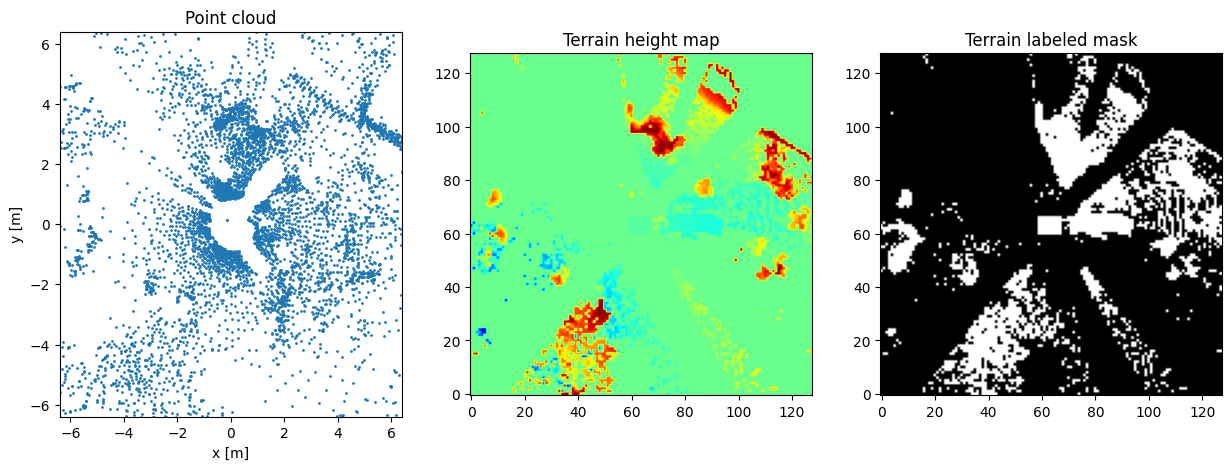

In [4]:
points, terrain = ds[0]

print(f'Points shape: {points.shape}')  # (3, N), N is the number of points
print(f'Terrain shape: {terrain.shape}')  # (2, H, W), stacked (height, labeled mask)

# visualize the point cloud and terrain height map
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
points_downsampled = points[:, ::10]
ax[0].scatter(points_downsampled[0], points_downsampled[1], s=1)
ax[0].set_title('Point cloud')
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
ax[0].set_xlim(-6.4, 6.4)
ax[0].set_ylim(-6.4, 6.4)

ax[1].imshow(terrain[0].T, cmap='jet', origin='lower')
ax[1].set_title('Terrain height map')

ax[2].imshow(terrain[1].T, cmap='gray', origin='lower')
ax[2].set_title('Terrain labeled mask')

plt.show()

## Model: LiDARBEV

![](../docs/imgs/lidarbev.png)

The model is using a voxel grid representation of the point cloud as input.
We are cropping the point cloud part of the model without lidar encoder and decoder,
because they are responsible for the fusion of the lidar and camera data.
This example contains only the point cloud part of the model.

Reference: https://hanlab.mit.edu/projects/bevfusion

In [5]:
# Grid size: (H, W, D) = (64, 128, 128) means
# 64 height voxels, 128 width voxels, 128 depth voxels
# Voxel is a cube with size 0.1m x 0.1m x 0.1m
model = LiDARBEV(grid_conf=lss_config['grid_conf'], out_channels=1)
model.to(device)
print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')

Number of model parameters: 58179


In [6]:
loader = DataLoader(ds, batch_size=4, shuffle=True)

points, hm_terrain = next(iter(loader))
print(f'Points shape: {points.shape}')  # (B, 3, N), N is the number of points

Points shape: torch.Size([4, 3, 131072])


In [7]:
with torch.inference_mode():
    with torch.no_grad():
        out = model(points.to(device))
        print(f'Output shape: {out.shape}')  # (B, outC, H, W)

Output shape: torch.Size([4, 1, 128, 128])
